In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from t_sne import *
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE as s_TSNE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import scanpy as sc 
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

In [3]:
def get_quantitative_metrics(data, embedding, eps=0.00001):
    original_distances = pdist(data, metric='euclidean') + eps
    embedded_distances = pdist(embedding, metric='euclidean') + eps
    kl_divergence = np.sum(original_distances * np.log(original_distances / embedded_distances))
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)

    print("KL Divergence:", kl_divergence)
    print("Spearman's Rank Correlation:", spearman_corr)
    return kl_divergence, spearman_corr

def plot_embedding(embedding):
    anndata = sc.AnnData(embedding)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata)
    sc.tl.umap(anndata)
    leiden_labels = anndata.obs["leiden"].values
    sc.pl.umap(anndata, color="leiden")
    plt.show
    return leiden_labels

def get_clustering_metrics(labels, cluster_labels):
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}
    """.format(ari, ami, homogeneity, completeness))
    return ari, ami, homogeneity, completeness

In [4]:
X = pd.read_csv("data/mnist_train.csv")

def select_digits(x):
    digits = [0, 1, 8]
    num_samples = 200
    if x.name not in digits:
        return None
    return x.iloc[:num_samples, :]

X_selected = X.groupby(by=["label"]).apply(select_digits)
X_selected = X_selected.reset_index(drop=True)

X_numpy = X_selected.iloc[:, 1:].to_numpy().astype('float64')
y_true = X_selected.iloc[:, 0]

In [5]:
print(X_numpy[:5])
print(X_numpy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(600, 784)


Most effective values:
- compression_period: 300

In [33]:
num_iters=500
perplexity=20
lr=10.
momentum=0.9
compression_period=300
compression_term=1e-2

tsne = TSNE(num_iters, perplexity, lr, momentum, compression_period=compression_period, compression_term=compression_term, verbose=False, color=y_true)

In [34]:
# tsne.compression_period = 0
# tsne.num_iters = 500

Finding sigmas


100%|██████████| 500/500 [00:10<00:00, 46.52it/s]


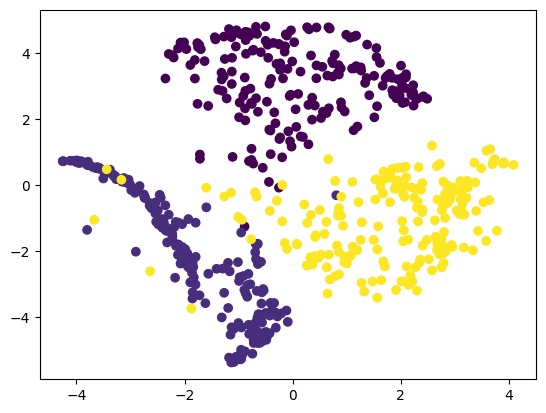

In [35]:
Y = tsne.fit(X_numpy)

plt.scatter(Y[:, 0], Y[:, 1], c=y_true)
plt.show()

/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/viktor/PythonProjects/MMML_project/venv/li

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['6', '6', '3', '3', '15', ..., '1', '0', '0', '0', '0']
Length: 600
Categories (19, object): ['0', '1', '2', '3', ..., '15', '16', '17', '18']

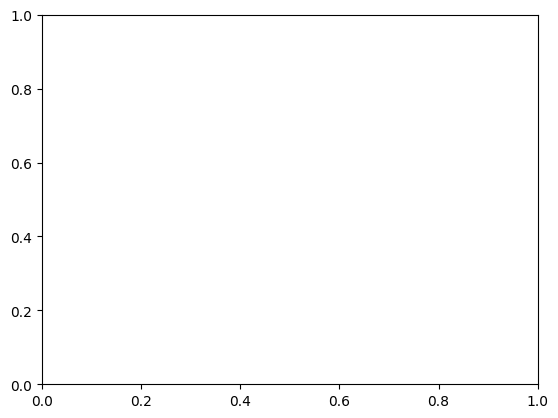

In [36]:
anndata = sc.AnnData(Y)
sc.pp.neighbors(anndata, use_rep="X")
sc.tl.leiden(anndata)
leiden_labels = anndata.obs["leiden"].values

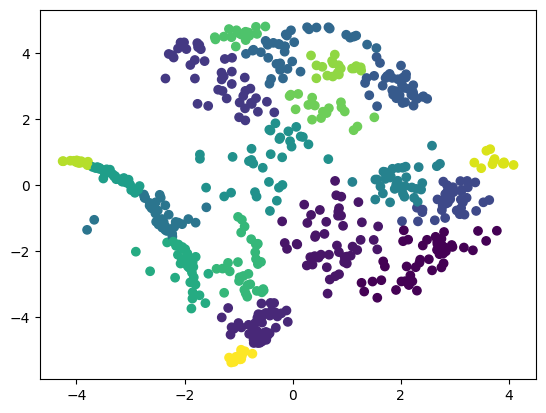

In [37]:
leiden_labels = [int(i) for i in leiden_labels]
plt.scatter(Y[:, 0], Y[:, 1], c=leiden_labels)
plt.show()

/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


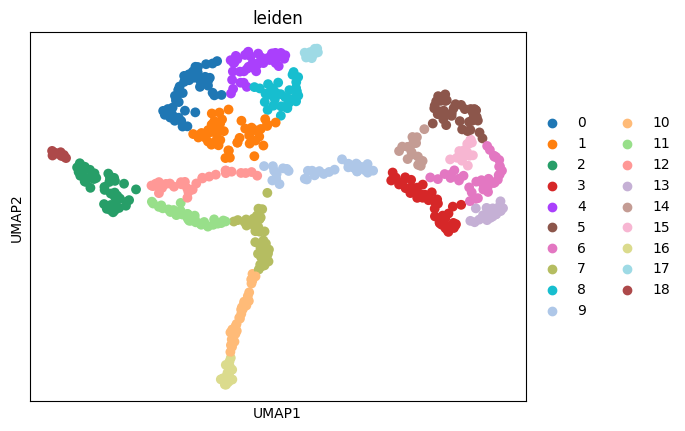

In [39]:
sc.tl.umap(anndata)
sc.pl.umap(anndata, color="leiden")

### Evaluation

In [18]:
# TODO: find labels for clustering
print("KL Divergence:", tsne.metrics['kl_divergence'])

KL Divergence: 0.6910360332469317


### sklearn

In [19]:
s_tsne = s_TSNE()
s_tsne.fit(X_numpy)

TSNE()

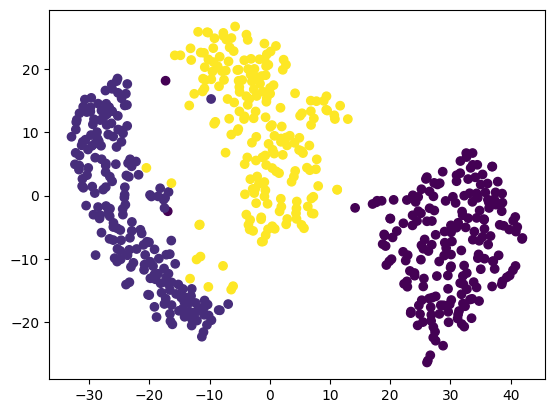

In [40]:
s_Y = s_tsne.embedding_
plt.scatter(s_Y[:, 0], s_Y[:, 1], c=y_true)
plt.show()

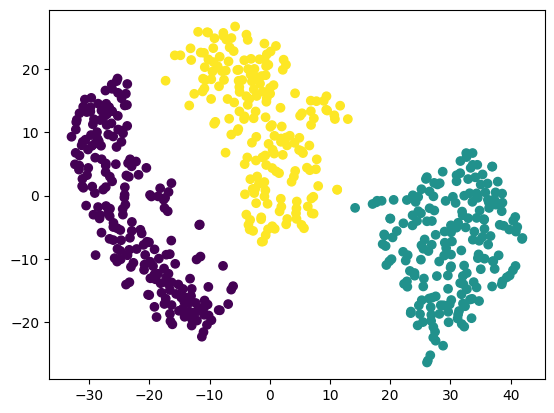

array([0, 1, 2])

In [47]:
anndata = sc.AnnData(s_Y)
sc.pp.neighbors(anndata, use_rep="X")
sc.tl.leiden(anndata, resolution=0.1)
leiden_labels = anndata.obs["leiden"].values

leiden_labels = np.array([int(i) for i in leiden_labels])
plt.scatter(s_Y[:, 0], s_Y[:, 1], c=leiden_labels)
plt.show()

np.unique(leiden_labels)

### K-means

In [32]:
kmeans = MiniBatchKMeans(n_clusters=3,
                        random_state=0,
                        batch_size=20,
                        max_iter=10,
                        n_init="auto").fit(Y)
y_hat = kmeans.labels_

In [33]:
print(y_true[:20])
print(y_hat[:20])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: label, dtype: int64
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### PCA

In [ ]:
pca = PCA()

pca.fit_transform(X_numpy)

cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [ ]:
n_components = np.min(np.where(cum_var_explained > 0.9)[0])
n_components

In [ ]:
V = pca.components_[:n_components].T

X_transform = X_numpy @ V

print(X_transform.shape)

### Save

In [ ]:
with open("data/reduced.npy", "wb") as f:
    np.save(f, Y)